# 安裝所需套件與建立函數

In [37]:
# 安裝所需套件
## 資料處理
import pandas as pd
from pandas import Series, DataFrame, concat
import numpy as np
from numpy import concatenate
from numpy import array
from math import sqrt
from numpy.random import seed
from datetime import datetime
# seed(1)

## 繪圖
import matplotlib.pyplot as plt
import seaborn as sns

## 資料清洗與模型建構、訓練
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras import regularizers

In [44]:
import yfinance as yf
import pandas as pd

# 抓取股票資料 (# stock_id = '^TWII' # stock_id = '2330.TW')
stock_id = '2330.TW'
data = yf.Ticker(stock_id)
df_stock = data.history(period="max")
# 增加股票代號
df_stock['stock_id'] = stock_id
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_id
Date,,,,,,,,
2000-01-04 00:00:00+08:00,35.393482,35.393482,34.796967,35.393482,200662336736,0.0,0.0,2330.TW
2000-01-05 00:00:00+08:00,35.393496,36.188786,34.995756,36.188786,402466805912,0.0,0.0,2330.TW
2000-01-06 00:00:00+08:00,35.989997,36.188772,35.393482,35.393482,197545715802,0.0,0.0,2330.TW
2000-01-07 00:00:00+08:00,34.200460,34.796975,33.802720,34.399235,235270344752,0.0,0.0,2330.TW
2000-01-10 00:00:00+08:00,35.393487,35.791037,34.796972,35.592262,276171685539,0.0,0.0,2330.TW
...,...,...,...,...,...,...,...,...
2023-02-06 00:00:00+08:00,532.000000,533.000000,526.000000,526.000000,30870136,0.0,0.0,2330.TW
2023-02-07 00:00:00+08:00,524.000000,528.000000,522.000000,523.000000,23481767,0.0,0.0,2330.TW
2023-02-08 00:00:00+08:00,538.000000,540.000000,534.000000,540.000000,35096191,0.0,0.0,2330.TW


In [45]:
df_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5766.000000,5766.000000,5766.000000,5766.000000,5.766000e+03,5766.000000,5766.000000
mean,126.829935,127.802764,125.729184,126.800643,1.970580e+10,0.017018,0.001922
std,156.099839,157.142405,154.835597,156.003992,4.260912e+10,0.265236,0.046409
min,13.718357,14.032042,13.679288,13.953526,0.000000e+00,0.000000,0.000000
25%,30.820536,31.222620,30.375395,30.821718,2.907488e+07,0.000000,0.000000
50%,49.438117,49.779545,48.823558,49.221130,4.457087e+07,0.000000,0.000000
75%,158.175917,158.592185,156.927170,157.759659,1.617683e+10,0.000000,0.000000
max,670.199707,673.134889,663.350951,668.242920,4.476381e+11,8.000000,1.400000


In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #if n_in=2, t-2,t-1,t
    n_vars = 1 if type(data) is list else data.shape[1] #return feature numbers
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        #print n_int to i in inverted order[n_in,n_in-1,...,1]
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Random Forest Regressor ; SVR ; Bayesian Ridge Regression

In [54]:
# Set input number of timestamps and training days
seed = 64
np.random.seed(64)

## 將80%作為train；其他20%作為test
# n是要用幾天前的資料當X
train_percent = 0.8
n = 24

# 要採用的變數(x) 總共有：['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'] # Close一定要放
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
# features = ['Open', 'High', 'Low', 'Close', 'Volume']
features = ['Close']

# 是否要歸一化
scaled = False

# Model (Random Forest Regressor ; SVR ; Bayesian Ridge Regression)
Model = "Bayesian Ridge Regression"

In [55]:
from datetime import datetime
# 整理資料

## 將Volume=0的值移除
filt = df_stock['Volume'] > 0
df = df_stock.loc[filt]

## 將close這個欄位放到最右邊
cols = df.columns.tolist()                     
cols.insert(7, cols.pop(cols.index('Close')))   
df = df[cols] 

## 納入哪些變數
drop_features = []
for item in cols:
    if item not in features:
        drop_features.append(item)
df = df.drop(drop_features, axis = 1)
df

,Close
Date,
2000-01-04 00:00:00+08:00,35.393482
2000-01-05 00:00:00+08:00,36.188786
2000-01-06 00:00:00+08:00,35.393482
2000-01-07 00:00:00+08:00,34.399235
2000-01-10 00:00:00+08:00,35.592262
...,...
2023-02-06 00:00:00+08:00,526.000000
2023-02-07 00:00:00+08:00,523.000000
2023-02-08 00:00:00+08:00,540.000000


In [56]:
# set train index
n_train_index = int(train_percent*len(df))
#transfer dataframe to arrays
values = df.values
# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, n, 1)
print(reframed.head())

if scaled == True:
    # normalize features 歸一化到0,1之間
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    values = scaled
else:
    values = np.array(reframed)
# split into train and test sets
# 選取所有指標的t-24到t-1作為feature，將Close的t時刻作為target，也就是reframed的最後一個
train = values[:n_train_index, ]
test = values[n_train_index:, ]
# split into input and outputs
# 將Close作為y，該變數是第0個特徵
train_X, train_y = train[:, 0:-1], train[:, -1]
test_X, test_y = test[:, 0:-1], test[:, -1]
print(f'X train:{train_X.shape}, Y train:{train_y.shape}, X test:{test_X.shape}, Y test:{test_y.shape}')

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  var1(t-20)  var1(t-19)  \
24   35.393482   36.188786   35.393482   34.399235   35.592262   34.995743   
25   36.188786   35.393482   34.399235   35.592262   34.995743   35.990013   
26   35.393482   34.399235   35.592262   34.995743   35.990013   35.393482   
27   34.399235   35.592262   34.995743   35.990013   35.393482   36.188786   
28   35.592262   34.995743   35.990013   35.393482   36.188786   37.183029   

    var1(t-18)  var1(t-17)  var1(t-16)  var1(t-15)  ...  var1(t-9)  var1(t-8)  \
24   35.990013   35.393482   36.188786   37.183029  ...  38.376060  40.960884   
25   35.393482   36.188786   37.183029   36.586525  ...  40.960884  41.358643   
26   36.188786   37.183029   36.586525   36.586525  ...  41.358643  40.563351   
27   37.183029   36.586525   36.586525   36.188786  ...  40.563351  40.364380   
28   36.586525   36.586525   36.188786   36.984074  ...  40.364380  40.165604   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-

In [57]:
# 可以把value印出來看
pd.DataFrame(values, columns = reframed.columns)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,35.393482,36.188786,35.393482,34.399235,35.592262,34.995743,35.990013,35.393482,36.188786,37.183029,...,38.376060,40.960884,41.358643,40.563351,40.364380,40.165604,41.955139,42.551643,43.545921,42.551643
1,36.188786,35.393482,34.399235,35.592262,34.995743,35.990013,35.393482,36.188786,37.183029,36.586525,...,40.960884,41.358643,40.563351,40.364380,40.165604,41.955139,42.551643,43.545921,42.551643,42.750427
2,35.393482,34.399235,35.592262,34.995743,35.990013,35.393482,36.188786,37.183029,36.586525,36.586525,...,41.358643,40.563351,40.364380,40.165604,41.955139,42.551643,43.545921,42.551643,42.750427,42.352890
3,34.399235,35.592262,34.995743,35.990013,35.393482,36.188786,37.183029,36.586525,36.586525,36.188786,...,40.563351,40.364380,40.165604,41.955139,42.551643,43.545921,42.551643,42.750427,42.352890,41.955139
4,35.592262,34.995743,35.990013,35.393482,36.188786,37.183029,36.586525,36.586525,36.188786,36.984074,...,40.364380,40.165604,41.955139,42.551643,43.545921,42.551643,42.750427,42.352890,41.955139,41.358643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,459.000000,468.000000,455.000000,456.500000,457.000000,451.000000,446.000000,448.500000,453.000000,449.500000,...,486.500000,500.000000,505.000000,503.000000,543.000000,522.000000,530.000000,540.000000,542.000000,526.000000
5631,468.000000,455.000000,456.500000,457.000000,451.000000,446.000000,448.500000,453.000000,449.500000,458.500000,...,500.000000,505.000000,503.000000,543.000000,522.000000,530.000000,540.000000,542.000000,526.000000,523.000000
5632,455.000000,456.500000,457.000000,451.000000,446.000000,448.500000,453.000000,449.500000,458.500000,458.500000,...,505.000000,503.000000,543.000000,522.000000,530.000000,540.000000,542.000000,526.000000,523.000000,540.000000
5633,456.500000,457.000000,451.000000,446.000000,448.500000,453.000000,449.500000,458.500000,458.500000,481.000000,...,503.000000,543.000000,522.000000,530.000000,540.000000,542.000000,526.000000,523.000000,540.000000,540.000000


In [167]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import linear_model

if Model == "Random Forest Regressor":
    # 建立RandomForestRegressor模型
    model = RandomForestRegressor()
elif Model == "SVR":
    model = svm.SVR()
elif Model == "Bayesian Ridge Regression":
    model = linear_model.BayesianRidge()

# 使用訓練資料訓練模型
model.fit(train_X, train_y)
# 訓練資料的預測
yhat_train = model.predict(train_X)
    

if scaled == True:
    # Reshape維度
    yhat_train = yhat_train.reshape((yhat_train.shape[0], 1))
    # 將訓練資料預測結果與訓練資料input拼接起來，用scaler還原原始數據
    inv_yhat_train = concatenate((yhat_train, train_X), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,-1]
    # 用scaler還原原始的訓練資料數據
    inv_y_train = scaler.inverse_transform(train)
    inv_y_train = inv_y_train[:,-1]
else:
    inv_y_train, inv_yhat_train = train_y, yhat_train
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Training RMSE: %.3f' % rmse_train)
print('Training MAE: %.3f' %mean_absolute_error(inv_y_train, inv_yhat_train))
print('Training MSE: %.3f' %mean_squared_error(inv_y_train, inv_yhat_train))
print('Training R2 score: %.3f' %r2_score(inv_y_train, inv_yhat_train))

# 測試資料的績效
yhat_test = model.predict(test_X)
if scaled == True:
    # Reshape維度
    yhat_test = yhat_test.reshape((yhat_test.shape[0], 1))
    # 將測試資料預測結果與測試資料input拼接起來，用scaler還原原始數據
    inv_yhat_test = concatenate((yhat_test, test_X), axis=1)
    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_test = inv_yhat_test[:,-1]
    # 用scaler還原原始的測試資料數據
    inv_y_test = scaler.inverse_transform(test)
    inv_y_test = inv_y_test[:,-1]
else:
    inv_y_test, inv_yhat_test = test_y, yhat_test
rmse_test = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse_test)
print('Test MAE: %.3f' %mean_absolute_error(inv_y_test, inv_yhat_test))
print('Test MSE: %.3f' %mean_squared_error(inv_y_test, inv_yhat_test))
print('Test R2 score: %.3f' %r2_score(inv_y_test, inv_yhat_test))

Training RMSE: 1.148
Training MAE: 0.754
Training MSE: 1.318
Training R2 score: 0.999
Test RMSE: 7.435
Test MAE: 5.274
Test MSE: 55.279
Test R2 score: 0.998


In [168]:
import os
# STOCK = stock_id.replace('^','')
path = f'./{stock_id}_{Model}'
if not os.path.isdir(path):
    os.mkdir(path)

In [169]:
# 輸出Excel
train_period = df.index[n:n_train_index+n]
train_df = DataFrame({'True':inv_y_train}).set_index(train_period)
train_df['Predict'] = inv_yhat_train
train_df['Dataset'] = 'Train'

test_period = df.index[n_train_index+n:]
test_df = DataFrame({'True':inv_y_test}).set_index(test_period)
test_df['Predict'] = inv_yhat_test
test_df['Dataset'] = 'Test'
result_df = concat([train_df,test_df])
result_df.to_excel(f'./{path}/result_{features}_scale{scaled}.xlsx', index = False)

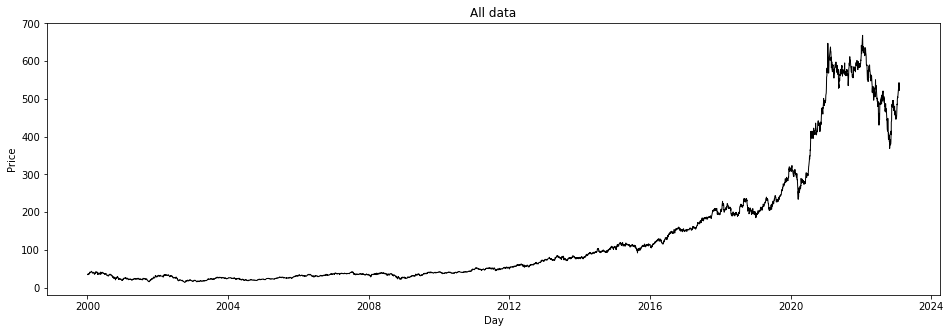

In [170]:
# Show results
plt.figure(figsize=(16,5))

all_period = df.index
plt.plot(all_period, np.array(df['Close']).astype('float32'), color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("All data")
plt.savefig(f'./{path}/alldata.png')#儲存圖片
plt.show()

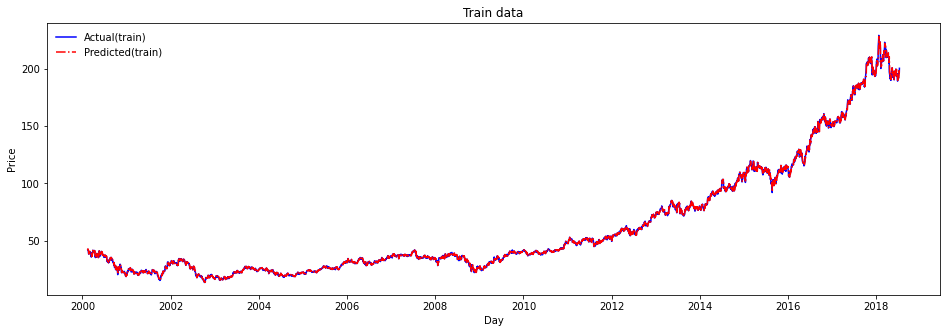

In [171]:
# Show results
plt.figure(figsize=(16,5))

# Train
train_period = df.index[n:n_train_index+n]
plt.plot(train_period, inv_y_train, c='blue', label='Actual(train)')
plt.plot(train_period, inv_yhat_train, c='red', linestyle='-.', label='Predicted(train)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Train data")

plt.savefig(f'./{path}/train_{features}_scale{scaled}.png')#儲存圖片
plt.show()

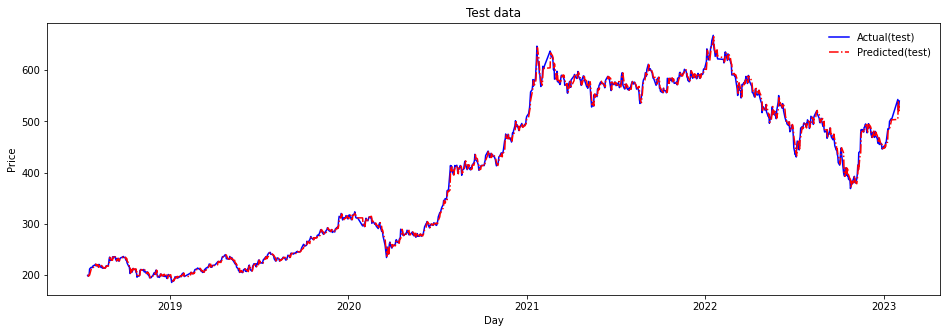

In [172]:
# Show results
plt.figure(figsize=(16,5))

test_period = df.index[n_train_index+n:]
plt.plot(test_period,inv_y_test,c='blue',label='Actual(test)')
plt.plot(test_period,inv_yhat_test,c='red',linestyle='-.',label='Predicted(test)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Test data")

plt.savefig(f'./{path}/test_{features}_scale{scaled}.png')#儲存圖片
plt.show()

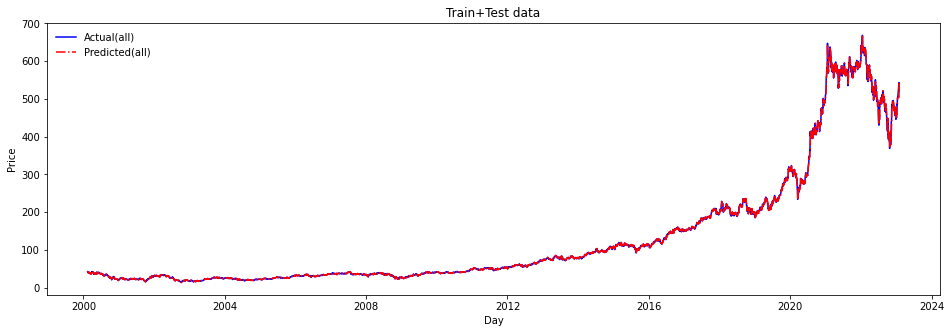

In [173]:
# Show results
plt.figure(figsize=(16,5))

predict_period = df.index[n:]
real = np.concatenate((inv_y_train, inv_y_test))
predict = np.concatenate((inv_yhat_train, inv_yhat_test))
plt.plot(predict_period,real,c='blue',label='Actual(all)')
plt.plot(predict_period,predict,c='red',linestyle='-.',label='Predicted(all)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Train+Test data")

plt.savefig(f'./{path}/predict_all_{features}_scale{scaled}.png')#儲存圖片
plt.show()

# LSTM

In [28]:
# 要抓的資料
stock_id = '2330.TW'
# stock_id = '^TWII'


## 將80%作為train；15%作為valid (約1年)；5%作為test (約1年)
n = 24
train_percent = 0.8
valid_percent = 0.15
# 要採用的變數(x) 總共有：['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'] # Close一定要放
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
features = ['Close']


# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
# 4: 一層LSTM，以及正則化(L1, L2 and Dropout regularisation)以避免overfit 
model_type = 2

In [29]:
import yfinance as yf
import pandas as pd

# 抓取股票資料
data = yf.Ticker(stock_id)
df = data.history(period="max")
# 增加股票代號
df['stock_id'] = stock_id
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_id
Date,,,,,,,,
2000-01-04 00:00:00+08:00,35.393497,35.393497,34.796982,35.393497,200662336736,0.0,0.0,2330.TW
2000-01-05 00:00:00+08:00,35.393488,36.188778,34.995748,36.188778,402466805912,0.0,0.0,2330.TW
2000-01-06 00:00:00+08:00,35.990012,36.188787,35.393497,35.393497,197545715802,0.0,0.0,2330.TW
2000-01-07 00:00:00+08:00,34.200460,34.796975,33.802720,34.399235,235270344752,0.0,0.0,2330.TW
2000-01-10 00:00:00+08:00,35.393491,35.791041,34.796976,35.592266,276171685539,0.0,0.0,2330.TW
...,...,...,...,...,...,...,...,...
2023-02-03 00:00:00+08:00,540.000000,542.000000,536.000000,542.000000,31635865,0.0,0.0,2330.TW
2023-02-06 00:00:00+08:00,532.000000,533.000000,526.000000,526.000000,30870136,0.0,0.0,2330.TW
2023-02-07 00:00:00+08:00,524.000000,528.000000,522.000000,523.000000,23481767,0.0,0.0,2330.TW


In [30]:
# 讀取資料
from datetime import datetime
# 整理資料

## 將Volume=0的值移除
filt = df['Volume'] > 0
df = df.loc[filt]

## 將close這個欄位放到最右邊
cols = df.columns.tolist()                     
cols.insert(7, cols.pop(cols.index('Close')))   
df = df[cols] 

## 納入哪些變數
drop_features = []
for item in cols:
    if item not in features:
        drop_features.append(item)
df = df.drop(drop_features, axis = 1)
df

,Close
Date,
2000-01-04 00:00:00+08:00,35.393497
2000-01-05 00:00:00+08:00,36.188778
2000-01-06 00:00:00+08:00,35.393497
2000-01-07 00:00:00+08:00,34.399235
2000-01-10 00:00:00+08:00,35.592266
...,...
2023-02-03 00:00:00+08:00,542.000000
2023-02-06 00:00:00+08:00,526.000000
2023-02-07 00:00:00+08:00,523.000000


In [31]:
#transfer dataframe to arrays
values = df.values
# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, n, 1)

# normalize features 歸一化到0,1之間
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

print(reframed.head())

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  var1(t-20)  var1(t-19)  \
24   35.393497   36.188778   35.393497   34.399235   35.592266   34.995747   
25   36.188778   35.393497   34.399235   35.592266   34.995747   35.990002   
26   35.393497   34.399235   35.592266   34.995747   35.990002   35.393497   
27   34.399235   35.592266   34.995747   35.990002   35.393497   36.188778   
28   35.592266   34.995747   35.990002   35.393497   36.188778   37.183033   

    var1(t-18)  var1(t-17)  var1(t-16)  var1(t-15)  ...  var1(t-9)  var1(t-8)  \
24   35.990002   35.393497   36.188778   37.183033  ...  38.376064  40.960896   
25   35.393497   36.188778   37.183033   36.586525  ...  40.960896  41.358639   
26   36.188778   37.183033   36.586525   36.586525  ...  41.358639  40.563332   
27   37.183033   36.586525   36.586525   36.188778  ...  40.563332  40.364384   
28   36.586525   36.586525   36.188778   36.984074  ...  40.364384  40.165607   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-

In [32]:
# split into train and test sets
n_train_index = int(train_percent*len(df))
n_valid_index = int((train_percent+valid_percent)*len(df))


values = scaled

# 選取所有指標的t-24到t-1作為feature，將開市的t時刻作為label，也就是reframed的最後一個
train = values[:n_train_index, ]
valid = values[n_train_index:n_valid_index, ]
test = values[n_valid_index:, ]
# split into input and outputs
train_X, train_y = train[:, 0:-1], train[:, -1]
valid_X, valid_y = valid[:, 0:-1], valid[:, -1]
test_X, test_y = test[:, 0:-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# 將每一行切割開，每一行作為一個輸入樣本，所以每個樣本有時間上的延遲關聯性。
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(f'X train:{train_X.shape}, Y train:{train_y.shape}, X valid:{valid_X.shape}, Y valid:{valid_y.shape}, X test:{test_X.shape}, Y test:{test_y.shape}')

X train:(4526, 1, 24), Y train:(4526,), X valid:(849, 1, 24), Y valid:(849,), X test:(259, 1, 24), Y test:(259,)


In [33]:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(10,input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(10, activation='relu'))
    model.add(Dense(1))

if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.25))         
    model.add(Dense(1, activation='tanh'))
    
if model_type == 4:
    # 一層LSTM，以及正則化(L1, L2 and Dropout regularisation)以避免overfit 
    model.add(LSTM(10,input_shape=(train_X.shape[1], train_X.shape[2]),
                   kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.2))
    ## 增加 output layer，激勵函數用tanh
    model.add(Dense(1, activation = 'tanh'))

In [34]:
# 建立LSTM資料夾
import os
path = f'./{stock_id}_LSTM'
if not os.path.isdir(path):
    os.mkdir(path)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 10)             1400      
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,251
Trainable params: 2,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
4526/4526 - 7s - loss: 1.9172e-05 - val_loss: 0.1207 - 7s/epoch - 2ms/step
Epoch 2/100
4526/4526 - 6s - loss: 1.6929e-04 - val_loss: 0.1046 - 6s/epoch - 1ms/step
Epoch 3/100
4526/4526 - 5s - loss: 1.5556e-04 - val_loss: 0.1237 - 5s/epoch - 1ms/step
Epoch 4/100
4526/4526 - 5s - loss: 2.1296e-04 - va

Epoch 85/100
4526/4526 - 6s - loss: 2.2907e-04 - val_loss: 0.1246 - 6s/epoch - 1ms/step
Epoch 86/100
4526/4526 - 5s - loss: 2.2907e-04 - val_loss: 0.1246 - 5s/epoch - 1ms/step
Epoch 87/100
4526/4526 - 5s - loss: 2.2907e-04 - val_loss: 0.1246 - 5s/epoch - 1ms/step
Epoch 88/100
4526/4526 - 6s - loss: 2.2907e-04 - val_loss: 0.1246 - 6s/epoch - 1ms/step
Epoch 89/100
4526/4526 - 6s - loss: 2.2907e-04 - val_loss: 0.1246 - 6s/epoch - 1ms/step
Epoch 90/100
4526/4526 - 5s - loss: 2.2907e-04 - val_loss: 0.1246 - 5s/epoch - 1ms/step
Epoch 91/100
4526/4526 - 5s - loss: 2.2907e-04 - val_loss: 0.1246 - 5s/epoch - 1ms/step
Epoch 92/100
4526/4526 - 5s - loss: 2.2907e-04 - val_loss: 0.1246 - 5s/epoch - 1ms/step
Epoch 93/100
4526/4526 - 6s - loss: 2.2907e-04 - val_loss: 0.1246 - 6s/epoch - 1ms/step
Epoch 94/100
4526/4526 - 6s - loss: 2.2907e-04 - val_loss: 0.1246 - 6s/epoch - 1ms/step
Epoch 95/100
4526/4526 - 7s - loss: 2.2907e-04 - val_loss: 0.1246 - 7s/epoch - 1ms/step
Epoch 96/100
4526/4526 - 6s - lo

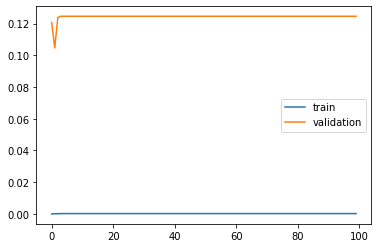

In [35]:
# 建構模型
## Model compiling
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# model.compile(loss='mae')
print(model.summary())

# 開始訓練
history = model.fit(train_X, train_y, epochs=100, batch_size=1, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

# loss/epoch
loss = history.history['loss']
epochs = range(len(loss))

# 視覺化訓練軌跡
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.savefig(f'./{stock_id}_LSTM/features_{features}_type{model_type}.png')
plt.legend()

In [36]:
# 訓練資料的預測
yhat_train = model.predict(train_X)
if model_type == 3:
    yhat_train = yhat_train.reshape((yhat_train.shape[0], yhat_train.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# 將訓練資料預測結果與訓練資料input拼接起來，用scaler還原原始數據
inv_yhat_train = concatenate((yhat_train, train_X), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]
# 用scaler還原原始的訓練資料數據
inv_y_train = scaler.inverse_transform(train)
inv_y_train = inv_y_train[:,-1]
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))

print('Training RMSE: %.3f' % rmse_train)
print('Training MAE: %.3f' %mean_absolute_error(inv_y_train, inv_yhat_train))
print('Training MSE: %.3f' %mean_squared_error(inv_y_train, inv_yhat_train))
print('Training R2 score: %.3f' %r2_score(inv_y_train, inv_yhat_train))

# 驗證資料的績效
yhat_valid = model.predict(valid_X)
if model_type == 3:
    yhat_valid = yhat_valid.reshape((yhat_valid.shape[0], yhat_valid.shape[2]))
valid_X = valid_X.reshape((valid_X.shape[0], valid_X.shape[2]))
# 將驗證資料預測結果與驗證資料input拼接起來，用scaler還原原始數據
inv_yhat_valid = concatenate((yhat_valid, valid_X), axis=1)
inv_yhat_valid = scaler.inverse_transform(inv_yhat_valid)
inv_yhat_valid = inv_yhat_valid[:,-1]
# 用scaler還原原始的驗證資料數據
inv_y_valid = scaler.inverse_transform(valid)
inv_y_valid = inv_y_valid[:,-1]
rmse_val = sqrt(mean_squared_error(inv_y_valid, inv_yhat_valid))
print('Validation RMSE: %.3f' % rmse_val)
print('Validation MAE: %.3f' %mean_absolute_error(inv_y_valid, inv_yhat_valid))
print('Validation MSE: %.3f' %mean_squared_error(inv_y_valid, inv_yhat_valid))
print('Validation R2 score: %.3f' %r2_score(inv_y_valid, inv_yhat_valid))

# 測試資料的績效
yhat_test = model.predict(test_X)
if model_type == 3:
    yhat_test = yhat_test.reshape((yhat_test.shape[0], yhat_test.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 將測試資料預測結果與測試資料input拼接起來，用scaler還原原始數據
inv_yhat_test = concatenate((yhat_test, test_X), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,-1]
# 用scaler還原原始的測試資料數據
inv_y_test = scaler.inverse_transform(test)
inv_y_test = inv_y_test[:,-1]
rmse_test = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse_test)
print('Test MAE: %.3f' %mean_absolute_error(inv_y_test, inv_yhat_test))
print('Test MSE: %.3f' %mean_squared_error(inv_y_test, inv_yhat_test))
print('Test R2 score: %.3f' %r2_score(inv_y_test, inv_yhat_test))

Training RMSE: 1.159
Training MAE: 0.754
Training MSE: 1.343
Training R2 score: 0.999
Validation RMSE: 6.275
Validation MAE: 4.426
Validation MSE: 39.372
Validation R2 score: 0.998
Test RMSE: 10.100
Test MAE: 7.828
Test MSE: 102.001
Test R2 score: 0.975


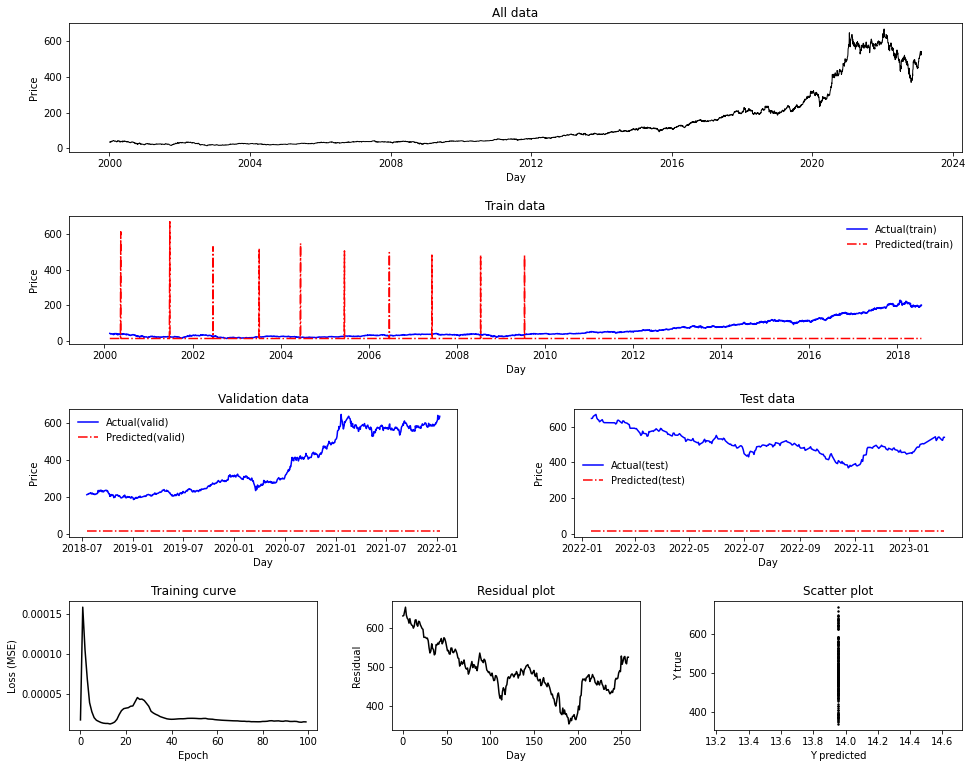

In [27]:
# Show results
plt.figure(figsize=(16,13))

plt.subplot(4, 1, 1)
all_period = df.index
plt.plot(all_period, np.array(df['Close']).astype('float32'), color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("All data")

# Train
train_period = df.index[n:n_train_index+n]
plt.subplot(4, 1, 2)
plt.plot(train_period, inv_y_train, c='blue', label='Actual(train)')
plt.plot(train_period, inv_yhat_train, c='red', linestyle='-.', label='Predicted(train)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Train data")

# Valid
valid_period = df.index[n_train_index+n:n_valid_index+n]
plt.subplot(4, 2, 5)
plt.plot(valid_period, inv_y_valid, c='blue', label='Actual(valid)')
plt.plot(valid_period, inv_yhat_valid, c='red', linestyle='-.', label='Predicted(valid)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Validation data")

# Test
test_period = df.index[n_valid_index+n:]
plt.subplot(4, 2, 6)
plt.plot(test_period,inv_y_test,c='blue',label='Actual(test)')
plt.plot(test_period,inv_yhat_test,c='red',linestyle='-.',label='Predicted(test)')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Test data")

plt.subplot(4, 3, 10)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(4, 3, 11)
plt.plot(inv_y_test-inv_yhat_test, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(4, 3, 12)
plt.scatter(inv_yhat_test, inv_y_test, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.savefig((f'./{stock_id}_LSTM/result_features_{features}_type{model_type}.png'))
plt.show()